In [1]:
# Comment out this line because Ken said to.
# %matplotlib inline

# Import matplotlib so we can make pretty graphs
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import more packages so we can analyze things.
# Whey are these in a separate cell? NO clue, but that's how this was set up.
import numpy as np
import pandas as pd

In [3]:
# I can't. Why another cell? Ridiculous.
# But this package should make it easier for us to manipulate dates and time (hence the name)
# LIES! THIS PACKAGE HAS THE AUDACITY TO CALL ITSELF 'DATETIME' AND THEN NAME A CLASS(?) INSIDE IT 
# 'DATETIME' TO MAKE EVERYTHING AS CONFUSING AS POSSIBLE. 
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
# crux to getting anything to work for this HW
import sqlalchemy 

# This means we can just be like "Hey! SQLAlchemy! 
# Take a look at this already made tables and tell me all about them"
from sqlalchemy.ext.automap import automap_base

# Sessions let's us start a database or table with SQLAlchemy?
from sqlalchemy.orm import Session

# Then again, maybe that's what engine does... f. Maybe engine lets ust connect with SQL?
# But func is great because we can use it to look for max, and min, and all these other basic functions. 
# Also, tossing in "inspect" so we can poke and prod at the DB.
from sqlalchemy import create_engine, func, inspect

In [5]:
# AH! we establish a connection with our sqlite server which is really just a file cuz it's lite. 
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# i.e. auto read my shit and tell me what I gots.
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
# This just means we can say "Measurement" instead of "Base.classes.measurement"
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
# Oh. well there ya go. We're connecting python to the database with a session. OBVI! *eye roll*
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data and plot the results
##### Calculate the date 1 year ago from the last data point in the database
##### Perform a query to retrieve the data and precipitation scores
##### Save the query results as a Pandas DataFrame and set the index to the date column
##### Sort the dataframe by date
##### Use Pandas Plotting with Matplotlib to plot the data

In [10]:
gadget = inspect(engine)
measure_cols = gadget.get_columns('Measurement')
station_cols = gadget.get_columns('Station')

for c in measure_cols:
    print(c['name'], c["type"])
    
for c in station_cols:
    print(c['name'], c["type"])

# Great! The Measurement database seems to have precipitation data and date data

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Query for just the date and the percipitation from the measurements
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
final = dt.datetime.strptime(latest[0], '%Y-%m-%d')
last12= final - dt.timedelta(days = 365)
# WHO THOUGHT DATETIME INSIDE DATETIME IS A LEGIT WAY TO NAME THINGS?

date_prec = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).\
    filter(Measurement.date > last12).all()

date = [row[0] for row in date_prec]
prec = [row[1] for row in date_prec]

# (grumph is clearly a better naming system. at least its emotionally descriptive)
grumph = pd.DataFrame(date, columns = ['date'])
grumph['prcp'] = prec
grumph = grumph.set_index(['date'])
grumph = grumph.sort_values(by = ['date'], ascending = True)
grumph.head()



,prcp
date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,NaN


<Figure size 7200x5400 with 0 Axes>

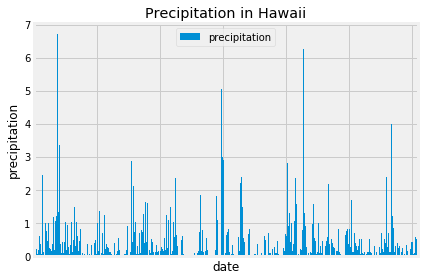

In [12]:
# Trying to plot in pandas. This. is. so. not. fun.
# Why does changing a random thing make the data appear? No idea.
# But it does. So... there 
plt.figure(figsize = (100,75))
grumph.plot.bar(title=f"Precipitation in Hawaii", width = 5)
plt.legend(loc="upper center")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.xlabel("date")
plt.ylabel("precipitation")
plt.legend(['precipitation'],loc = "upper center")
plt.xticks(pd.Series(np.arange(0,len(grumph),365)))
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

##### Use Pandas to calcualte the summary statistics for the precipitation data

In [13]:
# Summary stats
# I cannot tell you why they are different. just slightly. 
# At one point, I removed the rows with "None". But this has them in still and the count is the same.
# So maybe describe is taking into account the that nothing is in that row and it's not counted.
# MAYBE i was supposed to do this by hand rather than with the describe function. Meh.
grumph.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station, Station.name).distinct(Station.station).all()

for station in station_count:
    print(station[0], station[1])
print(f'There are a total of {len(station_count)} stations in this dataset')

USC00519397 WAIKIKI 717.2, HI US
USC00513117 KANEOHE 838.1, HI US
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US
USC00517948 PEARL CITY, HI US
USC00518838 UPPER WAHIAWA 874.3, HI US
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US
USC00519281 WAIHEE 837.5, HI US
USC00511918 HONOLULU OBSERVATORY 702.2, HI US
USC00516128 MANOA LYON ARBO 785.2, HI US
There are a total of 9 stations in this dataset


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
frick = session.query(Station.id)

station_again = engine.execute('SELECT Station.id, Station.station, name, count \
              FROM Station \
              INNER JOIN( \
                  SELECT station, count(id) count, id \
                  FROM Measurement \
                  GROUP BY station) AS SC \
              ON Station.station = SC.station \
              ORDER BY count DESC')

for station in station_again:
    print(station[0], station[1], station[2], station[3])
    
# while this is correct, it turns out that we cannot store this data in a useful way because we are bypassing
# the session and just talking with the DB. And this fucks it all up.
# BUT THIS WAS SO MUCH MORE INTUITIVE TO WRITE!!!

7 USC00519281 WAIHEE 837.5, HI US 2772
1 USC00519397 WAIKIKI 717.2, HI US 2724
2 USC00513117 KANEOHE 838.1, HI US 2709
6 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 2669
9 USC00516128 MANOA LYON ARBO 785.2, HI US 2612
3 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 2202
8 USC00511918 HONOLULU OBSERVATORY 702.2, HI US 1979
4 USC00517948 PEARL CITY, HI US 1372
5 USC00518838 UPPER WAHIAWA 874.3, HI US 511


In [16]:
# Well here's the query way. Why? Because of the reason stated above. So frustrating 
# "frick" is just a nice way of saying "gahfahkyaself!"
frick = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
    order_by((func.count(Measurement.station)).desc())
for f in frick:
    print(f[0], f[1])
    

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
columns = ["id", "low", "high", "average"]
temps = pd.DataFrame(columns = columns)

for station in frick:
    station_id = station[0]
    low = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).all()
    high = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).all()
    ave = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id).all()
    t = {"id": station_id, "low": low[0][0], "high": high[0][0], "average": ave[0][0]}
    temps = temps.append(t, ignore_index = True)
temps

,id,low,high,average
0,USC00519281,54.0,85.0,71.663781
1,USC00519397,56.0,87.0,74.553231
2,USC00513117,59.0,85.0,72.689184
3,USC00519523,56.0,85.0,74.543649
4,USC00516128,58.0,84.0,70.915008
5,USC00514830,58.0,85.0,74.873297
6,USC00511918,53.0,87.0,71.615968
7,USC00517948,58.0,87.0,74.684402
8,USC00518838,58.0,83.0,72.724070


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

latest = session.query(Measurement.date).\
    filter(Measurement.station == temps.id[0]).order_by(Measurement.date.desc()).first()
final = dt.datetime.strptime(latest[0], '%Y-%m-%d')
last12= final - dt.timedelta(days = 365)

high_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == temps.id[0]).\
    filter(Measurement.date > last12).all()

date = [row[0] for row in high_obs]
tobs = [row[1] for row in high_obs]

# (grumph is clearly a better naming system. at least its emotionally descriptive)
so_observed = pd.DataFrame(date, columns = ['date'])
so_observed['tobs'] = tobs


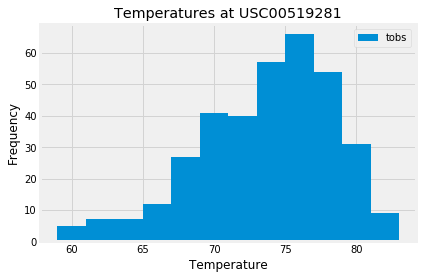

In [19]:
# Plot plot plot
plt.hist(x = so_observed.tobs, label = 'tobs', bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperatures at {temps.id[0]}")
plt.legend(loc = "upper right")
plt.grid(color='lightgrey', linestyle='-', linewidth=1)

![precipitation](Images/station-histogram.png)

# According to the git lab info, all this is optional. So.... BYE!

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
